# Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/Colab\ Notebooks/SudokuParser

/content/drive/MyDrive/Colab Notebooks/SudokuParser


In [14]:
# Load standard libraries and auxilliary functions:

from sudokuparserlib import *

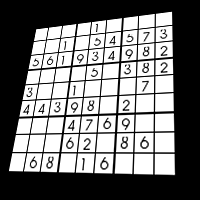

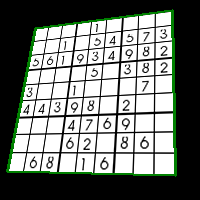

In [16]:
# sanity check:
X, y = generate_data(1,(200,200))
  
im = array_to_img(X[0])
display(im)
draw_polygon(im, y[0], width = 3, fill = 'green')
display(im)

# Setup DNN to detect corners of Sudoku

In [17]:
# generate some training, validation and test data
X_train, y_train = generate_data(6000, (200,200))
X_val, y_val = generate_data(600,(200,200))
X_test, y_test = generate_data(600,(200,200))

In [ ]:
# save data

np.save('./corners_data/X_train.npy', X_train)
np.save('./corners_data/y_train.npy', y_train)

np.save('./corners_data/X_val.npy', X_val)
np.save('./corners_data/y_val.npy', y_val)

np.save('./corners_data/X_test.npy', X_test)
np.save('./corners_data/y_test.npy', y_test)

In [ ]:
# load data

X_train = np.load('./corners_data/X_train.npy')
y_train = np.load('./corners_data/y_train.npy')

X_val = np.load('./corners_data/X_val.npy')
y_val = np.load('./corners_data/y_val.npy')

X_test = np.load('./corners_data/X_test.npy')
y_test = np.load('./corners_data/y_test.npy')

In [ ]:
# build convolutional neural network to recognize corners of a sudoku

# we will use this function to tweak the model parameters a bit

def setup_model():
  model = keras.Sequential(
      [
                keras.layers.Conv2D(
                    64, 
                    kernel_size = (3,3), 
                    padding = 'same', 
                    activation = "relu",  
                    input_shape = (200,200,1),
                    name = "Conv1"),
                keras.layers.MaxPool2D(name = "Pool1"),
                keras.layers.Conv2D(
                    32, 
                    kernel_size = (3,3), 
                    padding = 'same', 
                    activation = "relu", 
                    kernel_regularizer = keras.regularizers.L1(0.1), 
                    name = "Conv2"),
                keras.layers.MaxPool2D(name = "Pool2"),
                keras.layers.Conv2D(
                    16, 
                    kernel_size = (3,3), 
                    padding = 'same', 
                    activation = "relu", 
                    kernel_regularizer = keras.regularizers.L1(0.1),
                    name = "Conv3"),
                keras.layers.MaxPool2D(name = "Pool3"),
                keras.layers.Dropout(0.1, name = "Dropout1"),
                keras.layers.Flatten(name = "Flatten1"),
                keras.layers.Dense(
                    32, 
                    activation = "relu",
                    kernel_regularizer = keras.regularizers.L1(0.1),
                    name = "Dense1"),
                keras.layers.Dense(
                    8, 
                    activation = "relu", 
                    name = "FinalDense")          
      ]
  )

  model.compile(loss = "mse", optimizer = "adam")

  model.summary()
  
  return model

In [ ]:
model = setup_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 200, 64)      640       
                                                                 
 Pool1 (MaxPooling2D)        (None, 100, 100, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 100, 32)      18464     
                                                                 
 Pool2 (MaxPooling2D)        (None, 50, 50, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 50, 16)        4624      
                                                                 
 Pool3 (MaxPooling2D)        (None, 25, 25, 16)        0         
                                                                 
 Dropout1 (Dropout)          (None, 25, 25, 16)        0

In [ ]:
# stop early with patience 2
es = keras.callbacks.EarlyStopping('val_loss', patience = 3)
# save model at checkpoints to disk
mc = keras.callbacks.ModelCheckpoint('./corner_model_test.h5', monitor = 'val_loss', save_best_only = True)

# fit model to data
history = model.fit(X_train, y_train,
          epochs = 30,
          batch_size = 32, 
          validation_data=(X_val, y_val), 
          callbacks=[es, mc], 
          verbose = 1)

Epoch 1/30
188/188 [==============================] - 23s 55ms/step - loss: 4668.2412 - val_loss: 4045.9995
Epoch 2/30
188/188 [==============================] - 9s 48ms/step - loss: 3987.1077 - val_loss: 3999.4978
Epoch 3/30
188/188 [==============================] - 9s 49ms/step - loss: 3955.2644 - val_loss: 3985.9705
Epoch 4/30
188/188 [==============================] - 9s 49ms/step - loss: 3939.7947 - val_loss: 3969.9734
Epoch 5/30
188/188 [==============================] - 9s 49ms/step - loss: 3931.3987 - val_loss: 3960.9917
Epoch 6/30
188/188 [==============================] - 9s 49ms/step - loss: 3923.3154 - val_loss: 3951.3909
Epoch 7/30
188/188 [==============================] - 9s 49ms/step - loss: 3920.1069 - val_loss: 3950.5266
Epoch 8/30
188/188 [==============================] - 9s 49ms/step - loss: 3914.4163 - val_loss: 3948.4312
Epoch 9/30
188/188 [==============================] - 9s 49ms/step - loss: 3911.1494 - val_loss: 3941.4722
Epoch 10/30
188/188 [===============

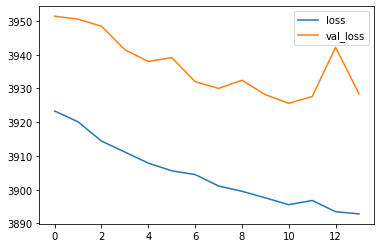

In [ ]:
import matplotlib.pyplot as plt

# plot the training progress
plt.plot(history.history['loss'][5:], label = 'loss')
plt.plot(history.history['val_loss'][5:], label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model via test data
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 22ms/step - loss: 3883.3303


3883.330322265625

In [ ]:
# After tweaking compare to previous model

model2 = keras.models.load_model('./corner_model.h5')

model2.evaluate(X_test, y_test)

19/19 [==============================] - 1s 22ms/step - loss: 28.6945


28.694520950317383

In [ ]:
# If it's better overwrite previous model
# %mv ./corner_model_test.h5 ./corner_model.h5

Now, let's see how it performs:

In [ ]:
# load model that predicts sudoku corners:

model = keras.models.load_model('./corner_model.h5')

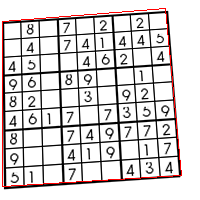

In [ ]:
im, corners, A = generate_random_mock_sudoku((200,200))
X = np.expand_dims(img_to_array(im), axis = 0)
z = model.predict(X)
draw_polygon(im, z[0], fill = 'red')
display(im)

# Setup DNN to classify Sudoku entries

In [ ]:
model = keras.models.load_model('./corner_model.h5')

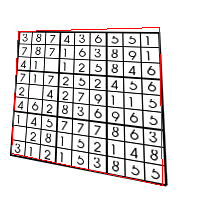

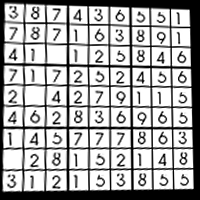

In [ ]:
# test if cropping sudoku numbers works:

im, corners, A = generate_random_mock_sudoku((200,200))
X = np.expand_dims(img_to_array(im), axis = 0)
z = model.predict(X)
A = X[0]
p = z[0]
draw_polygon(im,p, fill = 'red')
display(im)
imb = transform_back(A,p, margin = 2)
display(imb)
crops = crop_sudoku(imb, margin = 2)
for sud in crops:
  display(sud)

In [ ]:
# Use cropping to produce sample data of numbers

def generate_number_data(model, N = 500, size = (200, 200)):
  Xn_train = []
  yn_train = []

  for _ in range(N):
    im, _, A = generate_random_mock_sudoku(size)
    X = img_to_array(im)
    z = model.predict(np.expand_dims(X, axis = 0))[0]
    im = transform_back(X, z, margin = 2, size = size)
    Xn_train = Xn_train + crop_sudoku(im)
    yn_train = yn_train + list(np.concatenate(A))
  
  Xn_train = np.array(list(map(img_to_array, Xn_train)))
  yn_train = np.array(yn_train)

  return Xn_train, yn_train


In [ ]:
# generate some training data

Xn_train, yn_train = generate_number_data(model)
Xn_val, yn_val = generate_number_data(model, N = 50)
Xn_test, yn_test = generate_number_data(model, N = 50)

In [ ]:
# save data

np.save('./number_data/Xn_train.npy', Xn_train)
np.save('./number_data/yn_train.npy', yn_train)

np.save('./number_data/Xn_val.npy', Xn_val)
np.save('./number_data/yn_val.npy', yn_val)

np.save('./number_data/Xn_test.npy', Xn_test)
np.save('./number_data/yn_test.npy', yn_test)

In [ ]:
# load data

Xn_train = np.load('./number_data/Xn_train.npy')
yn_train = np.load('./number_data/yn_train.npy')

Xn_val = np.load('./number_data/Xn_val.npy')
yn_val = np.load('./number_data/yn_val.npy')

Xn_test = np.load('./number_data/Xn_test.npy')
yn_test = np.load('./number_data/yn_test.npy')

In [ ]:
# setup model to classify sudoku entries

# we will use this function to tweak the model parameters a bit

def setup_modeln_test():
  modeln = keras.Sequential(
      [   
          keras.layers.Flatten(input_shape = (25,25,1)),
          keras.layers.Dense(128,
                            activation = 'relu'),
          keras.layers.Dense(64,
                             activation = 'relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(10,
                            activation = 'softmax')
      ]
  )

  modeln.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
                optimizer = keras.optimizers.Adam(), 
                metrics = [keras.metrics.SparseCategoricalAccuracy()])
  
  modeln.summary()

  return modeln

In [ ]:
modeln_test = setup_modeln_test()

# stop early with patience 2
esn = keras.callbacks.EarlyStopping('sparse_categorical_accuracy', patience = 2)
# save model at checkpoints to disk
mcn = keras.callbacks.ModelCheckpoint('./number_model_test.h5', monitor = 'sparse_categorical_accuracy', save_best_only = True)

In [ ]:
# fit model to data
history = modeln_test.fit(Xn_train, yn_train,
          epochs = 5,
          batch_size = 32, 
          validation_data=(Xn_val, yn_val), 
          callbacks=[esn, mcn], 
          verbose = 1)


Epoch 1/5
1266/1266 [==============================] - 5s 4ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0845 - val_sparse_categorical_accuracy: 0.9756
Epoch 2/5
1266/1266 [==============================] - 5s 4ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0947 - val_sparse_categorical_accuracy: 0.9679
Epoch 3/5
1266/1266 [==============================] - 5s 4ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0647 - val_sparse_categorical_accuracy: 0.9807
Epoch 4/5
1266/1266 [==============================] - 5s 4ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0642 - val_sparse_categorical_accuracy: 0.9835
Epoch 5/5
1266/1266 [==============================] - 5s 4ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0557 - val_sparse_categorical_accuracy: 0.9854


In [ ]:
# evaluate model

modeln_test.evaluate(Xn_test, yn_test)

127/127 [==============================] - 0s 3ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9919


[0.02790059521794319, 0.9918518662452698]

In [ ]:
modeln = keras.models.load_model("./number_model.h5")

modeln.summary()

modeln.evaluate(Xn_test, yn_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 625)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               80128     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 89,034
Trainable params: 89,034
Non-trainable params: 0
_________________________________________________________________
127/127 [==============================] - 3s 2ms/

[0.028647979721426964, 0.9906172752380371]

In [ ]:
# If it's better then overwrite existing model:

# %cp ./number_model_test.h5 ./number_model.h5

# Put everything together to parse Sudoku

In [ ]:
# Load models:
model = keras.models.load_model('./corner_model.h5')
modeln = keras.models.load_model('./number_model.h5')

In [ ]:
# put everything together

def class_from_one_hot(z):
  return np.argmax(z)

def parse_sudoku(im, model, modeln):
  size = (200,200)
  im = im.resize(size)
  X = np.expand_dims(img_to_array(im), axis = 0)
  z = model.predict(X)
  A = X[0]
  p = z[0]
  imb = transform_back(A,p)
  crops = crop_sudoku(imb)
  
  Xn = np.array(list(map(img_to_array, crops)))
  zn = modeln.predict(Xn)

  return np.array(list(map(class_from_one_hot,zn))).reshape((9,9))


In [ ]:
im, corners, A = generate_random_mock_sudoku((200,200))

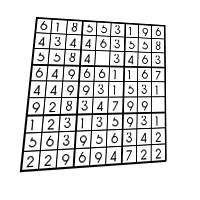

[[6 1 8 5 5 3 1 9 6]
 [4 3 4 4 6 3 5 5 8]
 [5 5 8 4 0 3 4 6 3]
 [6 4 9 6 6 1 1 6 7]
 [4 4 9 9 3 1 5 3 1]
 [9 2 8 3 4 7 9 9 0]
 [1 2 3 1 3 5 9 3 1]
 [5 6 3 9 5 6 3 4 2]
 [2 2 9 6 9 4 7 2 2]]
[[6 1 8 5 5 3 1 9 6]
 [4 3 4 4 6 3 5 5 8]
 [5 5 8 4 0 3 4 6 3]
 [6 4 9 6 6 1 1 6 7]
 [4 4 9 9 3 1 5 3 1]
 [9 2 8 3 4 7 9 9 0]
 [1 2 3 1 3 5 9 3 1]
 [5 6 3 9 5 6 3 4 2]
 [2 2 9 6 9 4 7 2 2]]
True


In [ ]:
display(im)
B = parse_sudoku(im, model, modeln)
print(A)
print(B)
print(np.array_equal(A,B))

# Evaluation

In [ ]:
# How accurately do we recognize sudokus?

N = 300

correct = 0.0

for i in range(N):
  im, corners, A = generate_random_mock_sudoku((200,200))
  B = parse_sudoku(im, model, modeln)
  if np.array_equal(A,B):
    correct = correct + 1
  

print(correct/N)

0.73


An accuracy of about 73% is not too bad given that we have to classify 81 numbers correctly!

Indeed, if we model the classification of all 81 numbers as a Bernoulli experiment with success rate $0 < p < 1$ then the event of making no mistake has probability $P = p^{81}$. Thus, if we want to achieve an accuracy of at least 73% we need a success rate of at least
$$p \geq 0.73^{1/81} \approx 99.65\%$$